### Daily SLIE QC
* Check the netCDF data to make sure they open
* Plot a few slices
* Play around with the data

In [1]:
import xarray as xr
import rasterio as rio
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from config import BEAUFORT_NETCDF_DIR, CHUKCHI_NETCDF_DIR
from luts import pixel_values, ice_years

In [2]:
daily_slie_colors = {
    0: [255, 255, 255],  # Not Landfast Ice (white)
    32: [191, 212, 212],  # Coast Vector Shadow (gray-green)
    64: [230, 230, 230],  # Out of Bounds (light gray)
    111: [230, 230, 230],  # nodata (light gray)
    128: [0, 100, 0],  # Land (dark green)
    255: [0, 0, 255],  # Landfast Ice (blue)
}
daily_slie_colors_normalized = {
    k: (r / 255, g / 255, b / 255) for k, (r, g, b) in daily_slie_colors.items()
}
daily_slie_cmap = mcolors.ListedColormap(
    [daily_slie_colors_normalized[k] for k in pixel_values.keys()]
)
boundaries = list(pixel_values.keys()) + [256]  # Add an upper bound for 255
norm = mcolors.BoundaryNorm(boundaries, daily_slie_cmap.N)

# cmap = mcolors.ListedColormap([colors[key] for key in pixel_values.keys()])
# bounds = list(pixel_values.keys()) + [256]  # Add an upper bound for color mapping
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

One `xarray` thing to note here it that even though we explicity prescribed an int data type in processing, you can see that xarray is defaulting to the `slie` data variable being float64. You can choose how to open the dataset though - see the below two cells:

In [3]:
ds = xr.open_dataset(BEAUFORT_NETCDF_DIR / "beaufort_sea_daily_slie_1996-97.nc")
ds

<xarray.Dataset> Size: 66GB
Dimensions:      (x: 9556, y: 3300, time: 260)
Coordinates:
  * x            (x) float64 76kB -2.362e+05 -2.36e+05 ... 7.192e+05 7.194e+05
  * y            (y) float64 26kB 2.51e+06 2.51e+06 ... 2.18e+06 2.18e+06
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 2kB 1996-10-27 1996-10-28 ... 1997-07-13
Data variables:
    slie         (time, y, x) float64 66GB ...
Attributes:
    crs:      EPSG:3338

In [4]:
ds = xr.open_dataset(BEAUFORT_NETCDF_DIR / "beaufort_sea_daily_slie_1996-97.nc", mask_and_scale=False)
ds

<xarray.Dataset> Size: 16GB
Dimensions:      (x: 9556, y: 3300, time: 260)
Coordinates:
  * x            (x) float64 76kB -2.362e+05 -2.36e+05 ... 7.192e+05 7.194e+05
  * y            (y) float64 26kB 2.51e+06 2.51e+06 ... 2.18e+06 2.18e+06
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 2kB 1996-10-27 1996-10-28 ... 1997-07-13
Data variables:
    slie         (time, y, x) int16 16GB ...
Attributes:
    crs:      EPSG:3338

In [5]:
def list_netcdf_files(directory):
    """
    Lists all NetCDF files in a given directory.

    Parameters:
        directory (Path): A pathlib.Path object representing the directory.

    Returns:
        list: A list of pathlib.Path objects for all files with a .nc extension.
    """
    return list(directory.glob("*.nc"))
beauf_ncs = list_netcdf_files(BEAUFORT_NETCDF_DIR)
chuk_ncs = list_netcdf_files(CHUKCHI_NETCDF_DIR)
assert len(chuk_ncs) == len(beauf_ncs) == len(ice_years)

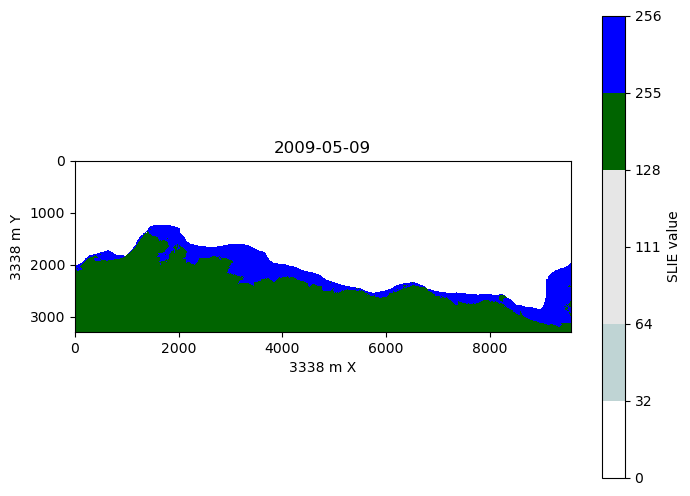

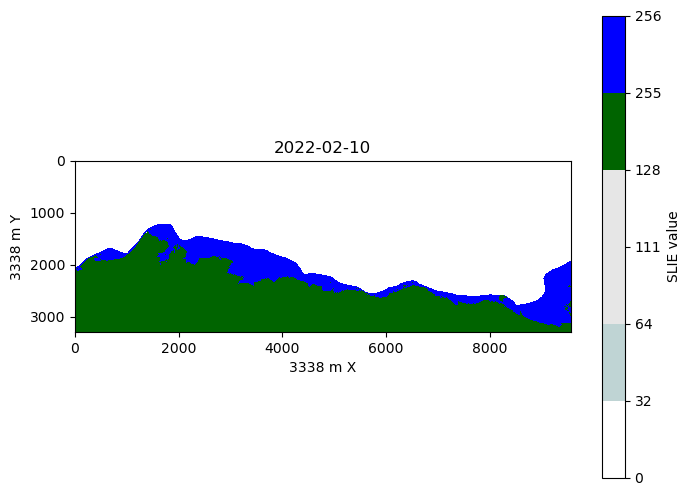

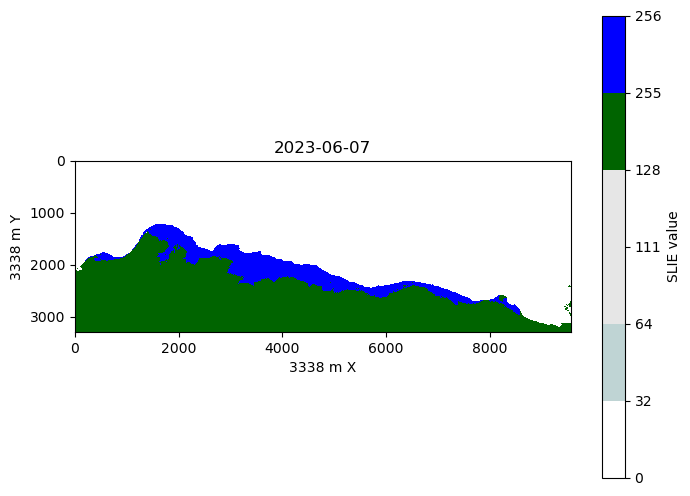

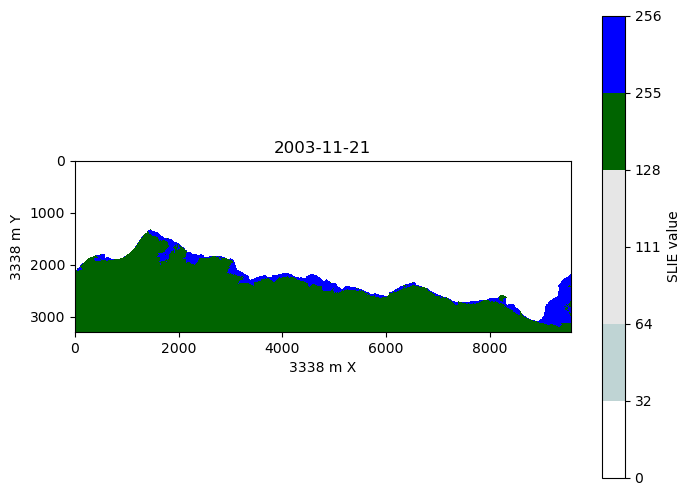

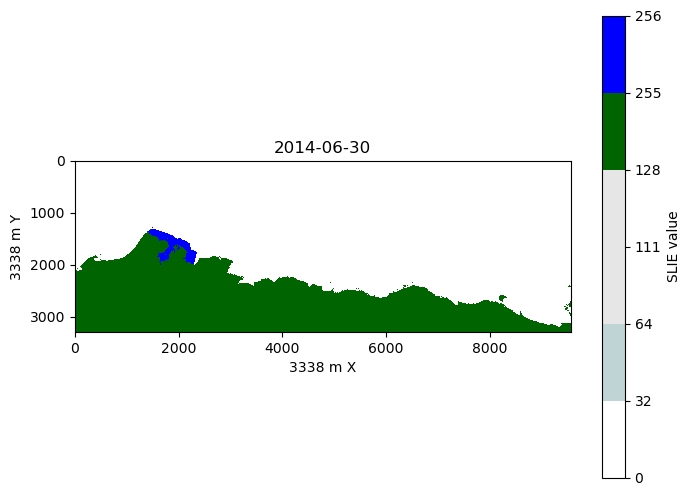

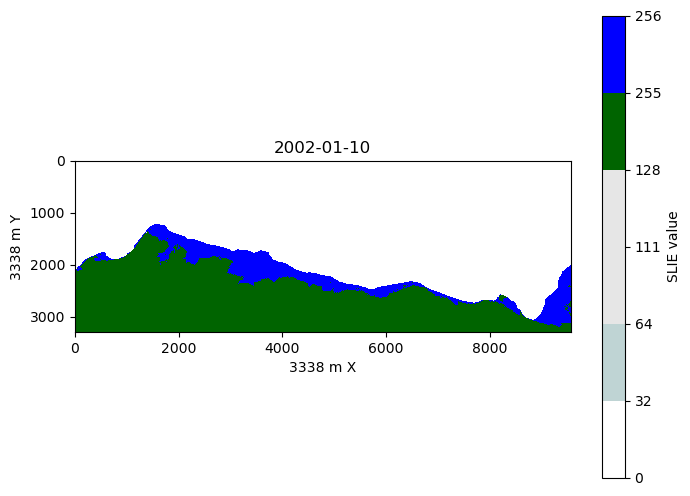

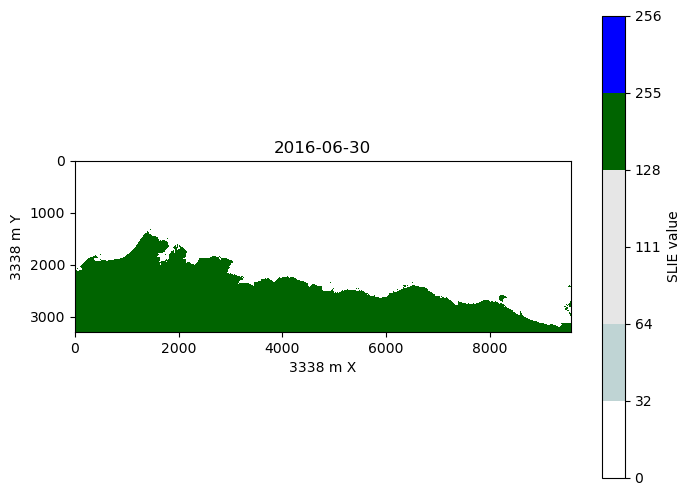

In [6]:
def plot_random_time_slices(netcdf_files):
    
    # Open the list of NetCDF files as a single xarray Dataset
    dataset = xr.open_mfdataset(netcdf_files, combine='by_coords')
    time_length = len(dataset['time'])

    # sample a small percentage of time slices
    num_slices = max(1, int(time_length * 0.001))

    # Generate random indices for the time slices
    random_indices = random.sample(range(time_length), num_slices)

    # Plot the random time slices
    for idx in random_indices:
        time_slice = dataset.isel(time=idx)
        plt.figure(figsize=(8, 6))
        plt.imshow(time_slice["slie"], cmap=daily_slie_cmap, norm=norm, interpolation="none")
        plt.colorbar(label="SLIE value")
        plt.title(str(pd.to_datetime(time_slice.time.values).date()))
        #plt.title(f"{pd.to_datetime(time_slice.values).date()}")
        plt.xlabel("3338 m X")
        plt.ylabel("3338 m Y")
        plt.show()
    dataset.close()
plot_random_time_slices(beauf_ncs)

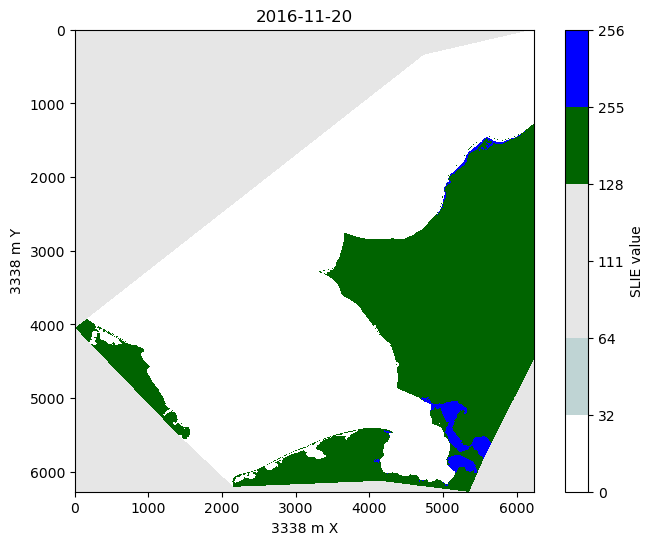

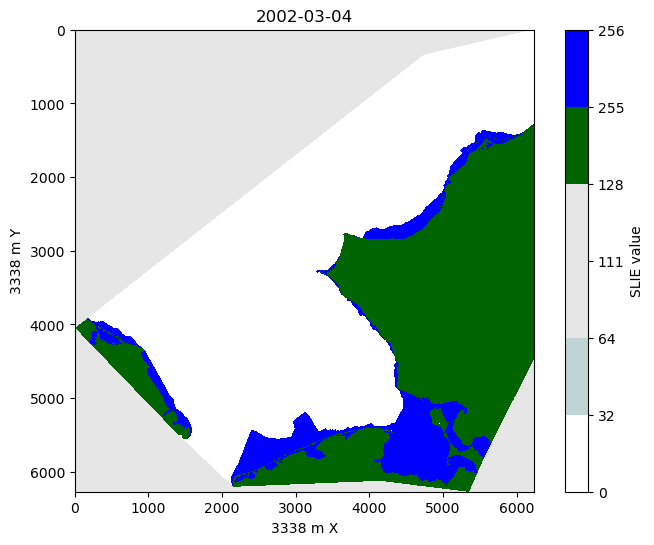

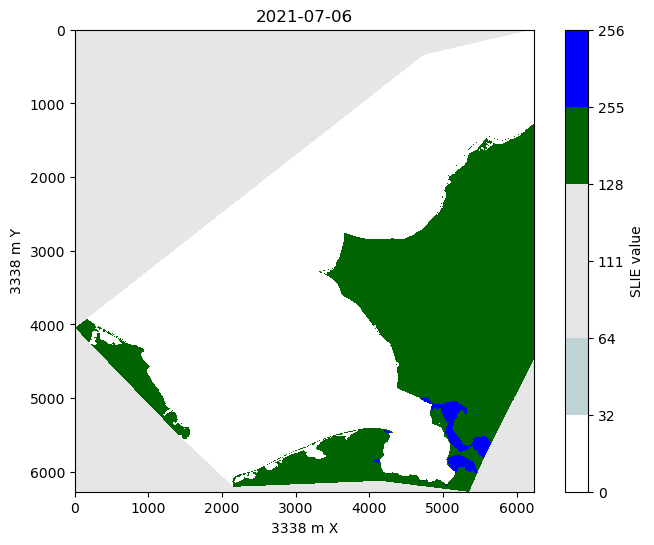

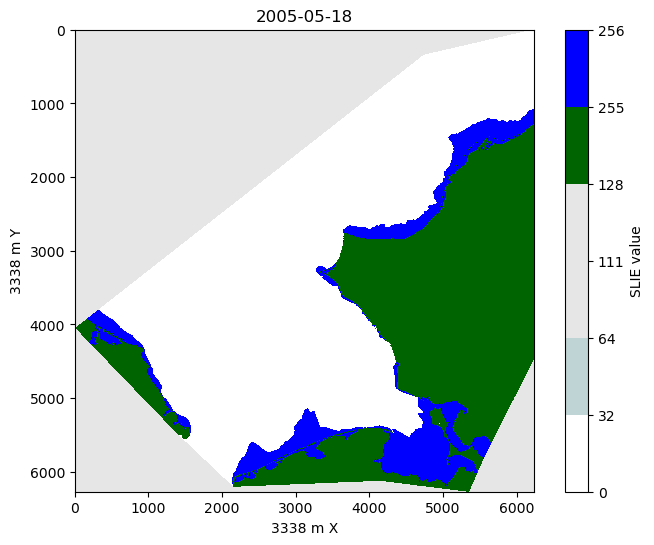

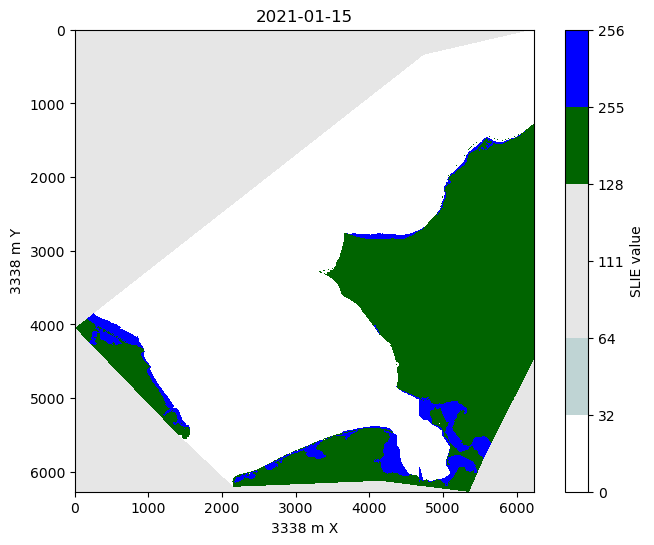

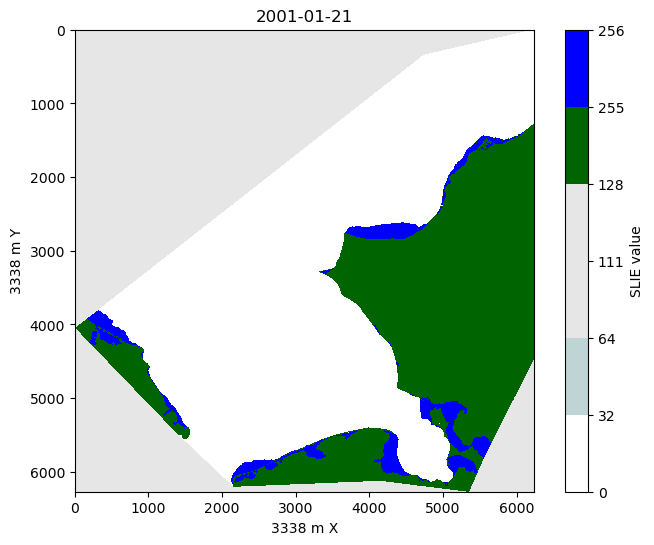

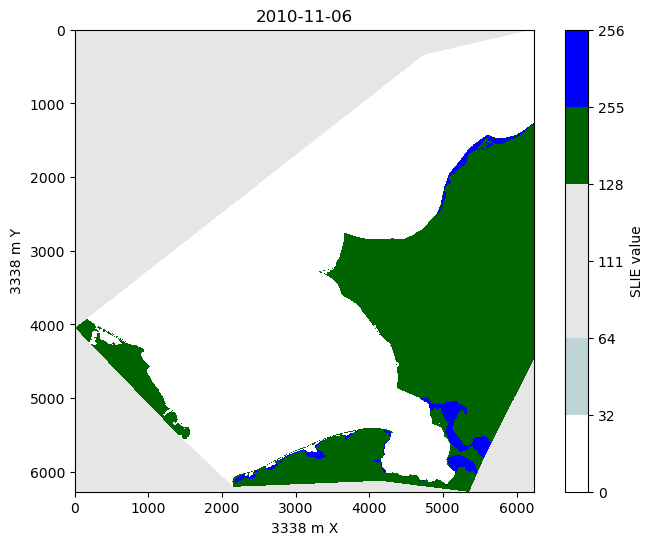

In [7]:
plot_random_time_slices(chuk_ncs)

In [8]:
# Here are some points of interest to sample
nearest_neighbors = {
    'Deadhorse': {'nearest_neighbor_x': 210868.41898, 'nearest_neighbor_y': 2266378.89492},
    'Kaktovik': {'nearest_neighbor_x': 397108.13843, 'nearest_neighbor_y': 2267302.40486},
    'Nuiqsut': {'nearest_neighbor_x': 107582.87949, 'nearest_neighbor_y': 2265757.97764},
    'Prudhoe Bay': {'nearest_neighbor_x': 215276.75919, 'nearest_neighbor_y': 2267138.77673},
    'Utqiaġvik': {'nearest_neighbor_x': -102597.06776, 'nearest_neighbor_y': 2368251.60593},
    'Wainwright': {'nearest_neighbor_x': -236276.26846, 'nearest_neighbor_y': 2304971.31783},
    'Candle': {'nearest_neighbor_x': -360055.77799, 'nearest_neighbor_y': 1804181.96468},
    'Cape Lisburne': {'nearest_neighbor_x': -494853.87917, 'nearest_neighbor_y': 2146066.03177},
    'Deering': {'nearest_neighbor_x': -394304.82266, 'nearest_neighbor_y': 1816799.19935},
    'Diomede': {'nearest_neighbor_x': -677501.22952, 'nearest_neighbor_y': 1833899.2719},
    'Elephant Point': {'nearest_neighbor_x': -329718.3704, 'nearest_neighbor_y': 1830434.80902},
    'Kivalina': {'nearest_neighbor_x': -446876.42931, 'nearest_neighbor_y': 2009841.09612},
    'Kiwalik': {'nearest_neighbor_x': -355159.97287, 'nearest_neighbor_y': 1807151.7589},
    'Kotzebue': {'nearest_neighbor_x': -377200.61298, 'nearest_neighbor_y': 1906880.17964},
    'Point Hope': {'nearest_neighbor_x': -526228.42456, 'nearest_neighbor_y': 2093141.82263},
    'Point Lay': {'nearest_neighbor_x': -354077.66064, 'nearest_neighbor_y': 2222399.58791},
    'Shishmaref': {'nearest_neighbor_x': -541106.53038, 'nearest_neighbor_y': 1860348.96552},
    'Tin City': {'nearest_neighbor_x': -644439.95796, 'nearest_neighbor_y': 1803067.85104},
    'Wales': {'nearest_neighbor_x': -645546.82339, 'nearest_neighbor_y': 1807631.0954}
}


In [9]:
def plot_binary_time_series(data, times, location):
    """
    Plot the binary ice condition over time.

    Args:
        data (array): The ice condition data (values of 0 or 255).
        times (array): The corresponding time values.
        location (str): The name of the location being plotted.
    """
    # Convert 255 to 1 for easier visualization
    binary_data = np.where(data == 255, 1, 0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(times, binary_data, drawstyle='steps-post')
    plt.yticks([0, 1], labels=['Not Landfast Ice', 'Landfast Ice'])
    plt.xlabel('Time')
    plt.ylabel('Condition')
    plt.title(f'Ice Condition Over Time for Grid Cell Near {location}')
    plt.grid(True)
    plt.show()


def extract_and_plot_timeseries():
    """
    Extract the time series for each location from the dataset and plot the binary ice condition.

    Args:
        ds (xarray.Dataset): The dataset containing the 'slie' variable with x, y, and time dimensions.
    """
    i = 0
    for location, coords in nearest_neighbors.items():
        x = coords['nearest_neighbor_x']
        y = coords['nearest_neighbor_y']

        if i <= 5:
            ds = xr.open_mfdataset(beauf_ncs, combine='by_coords')
        else:
            ds = xr.open_mfdataset(chuk_ncs, combine='by_coords')
        time_series = ds.slie.sel(x=x, y=y, method="nearest")
        # Plot the binary time series
        plot_binary_time_series(time_series.values, time_series.time.values, location)
        i += 1



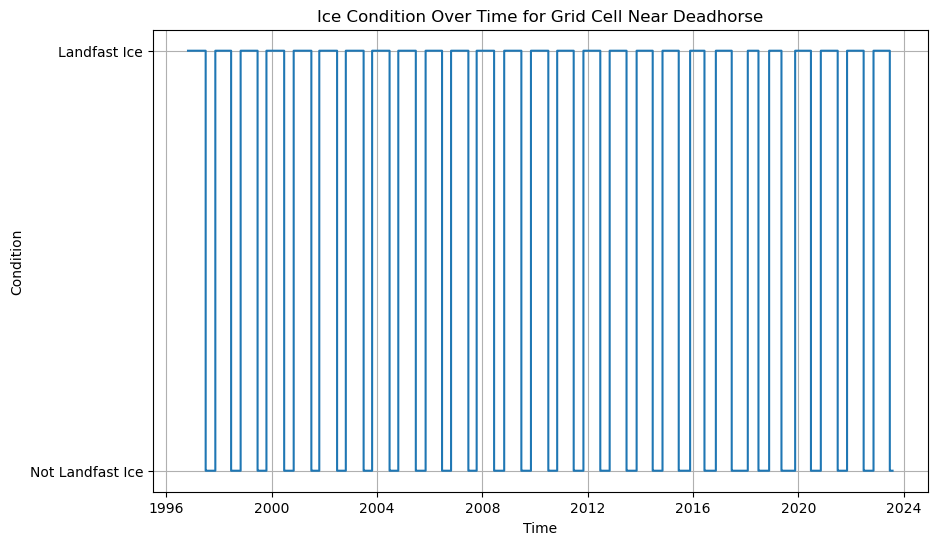

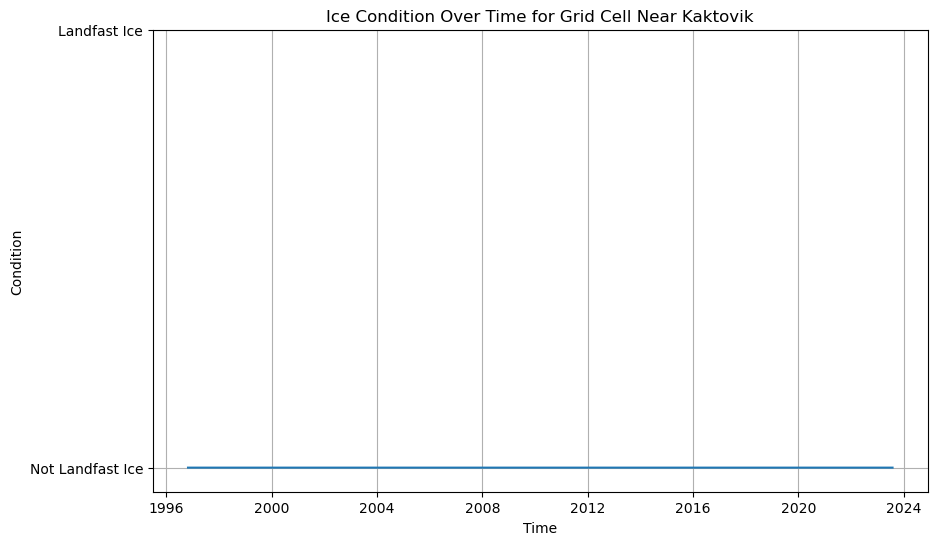

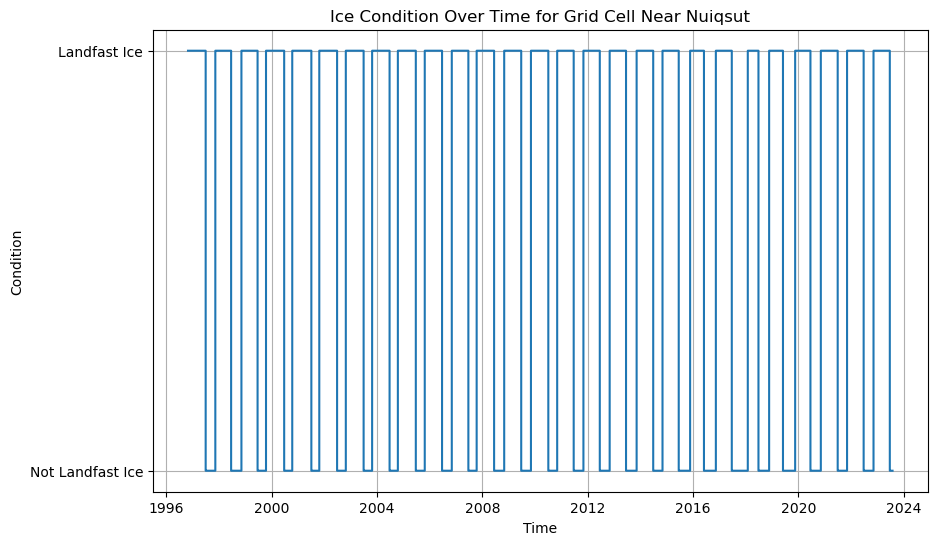

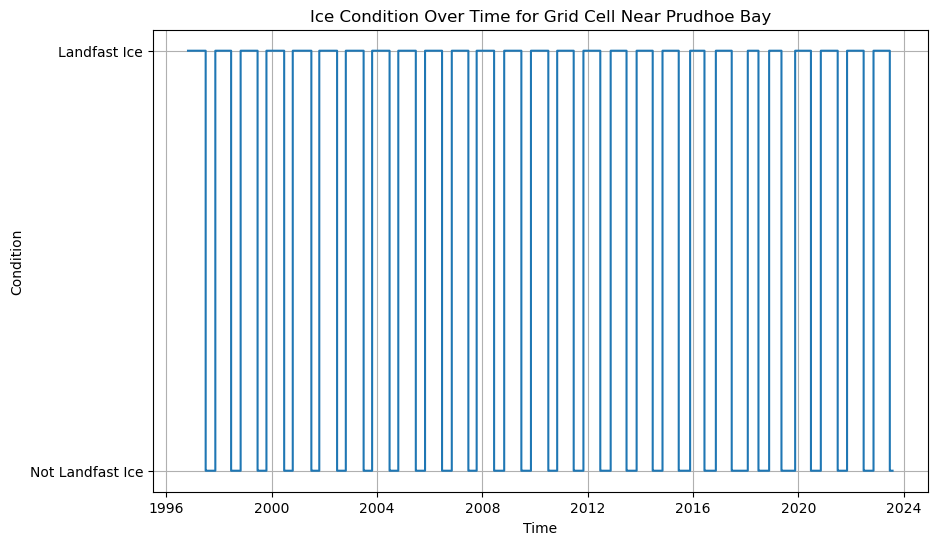

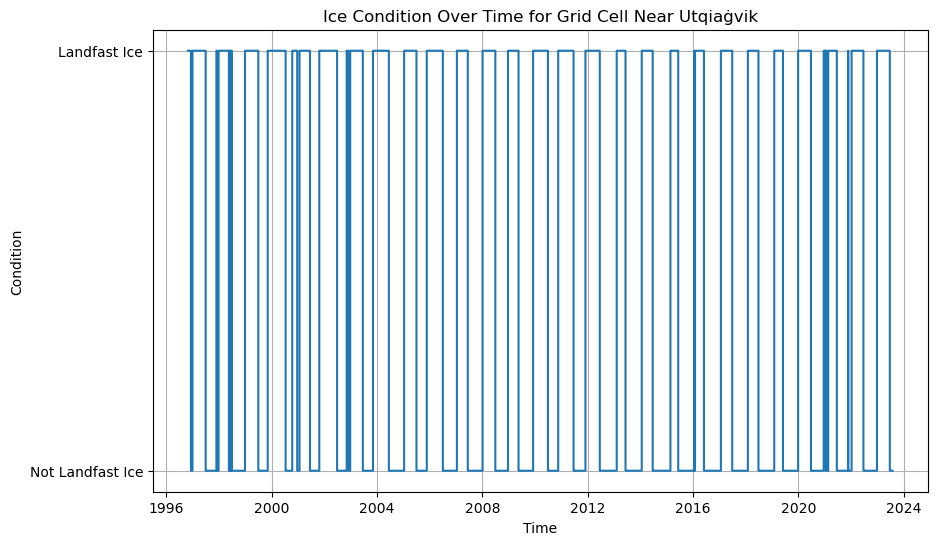

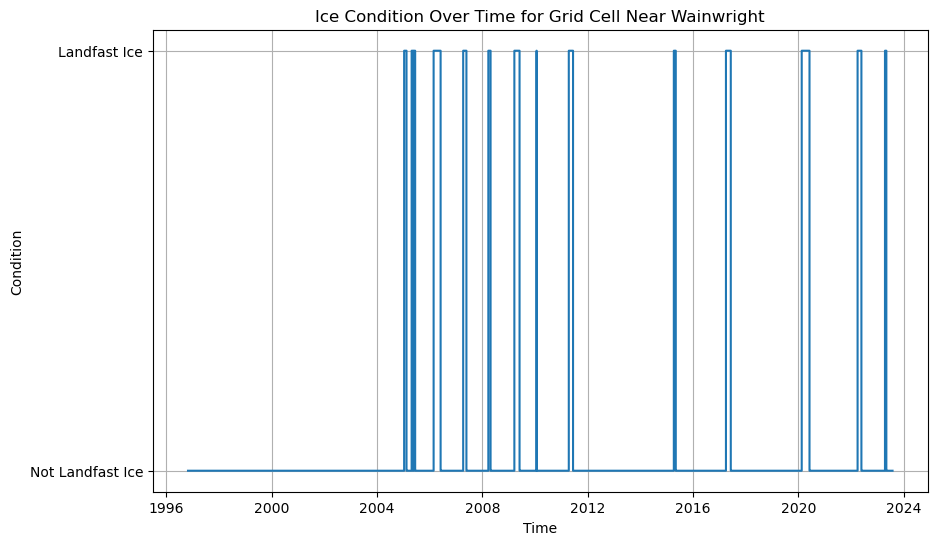

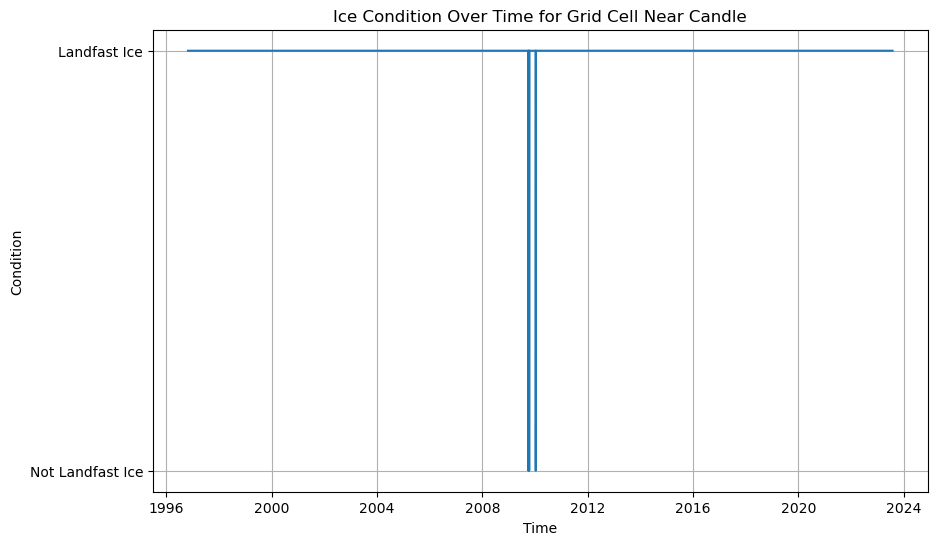

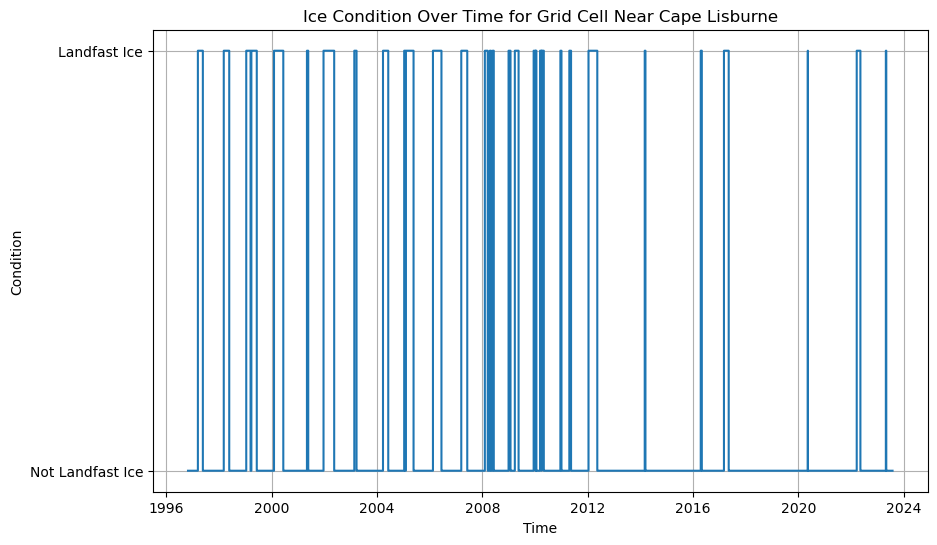

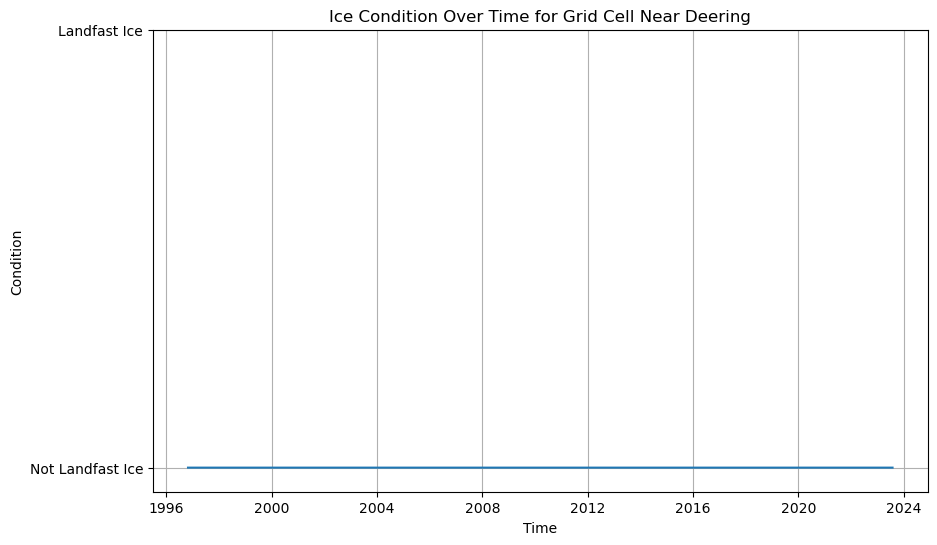

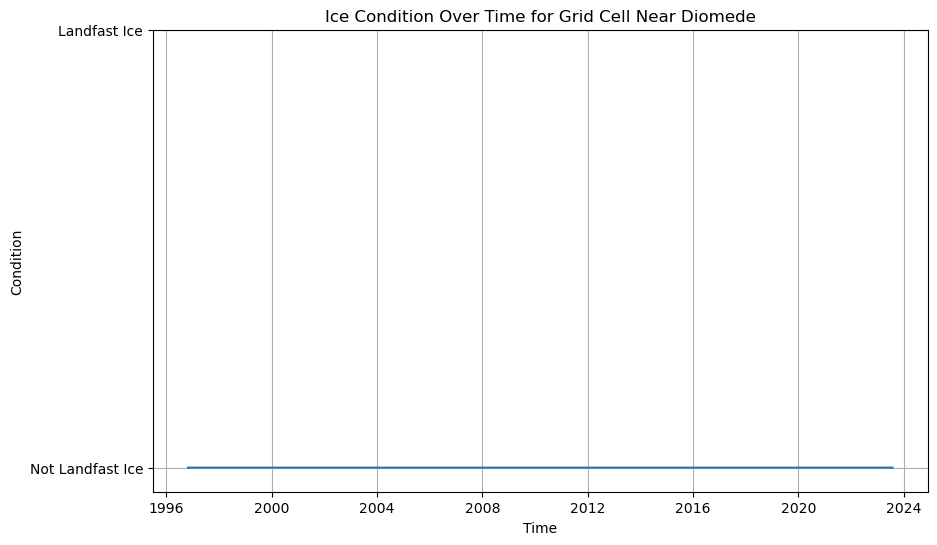

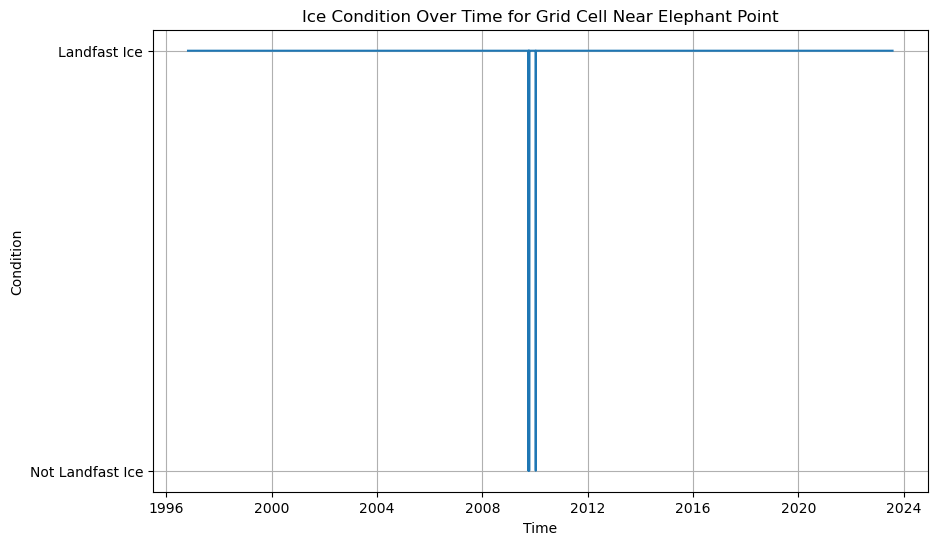

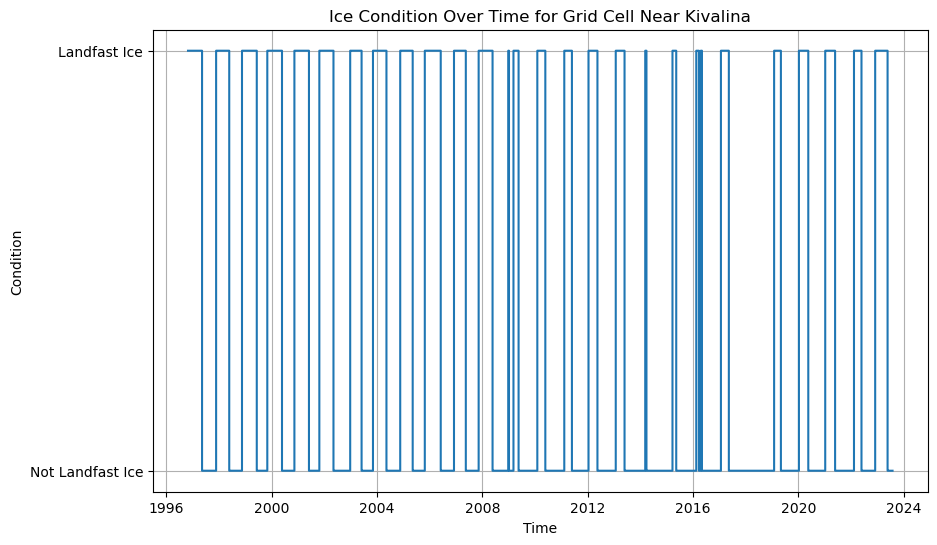

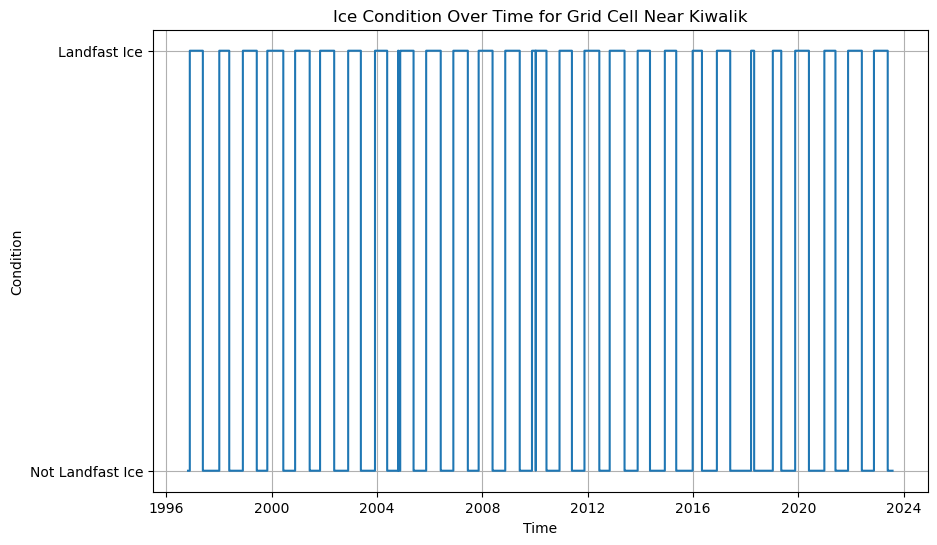

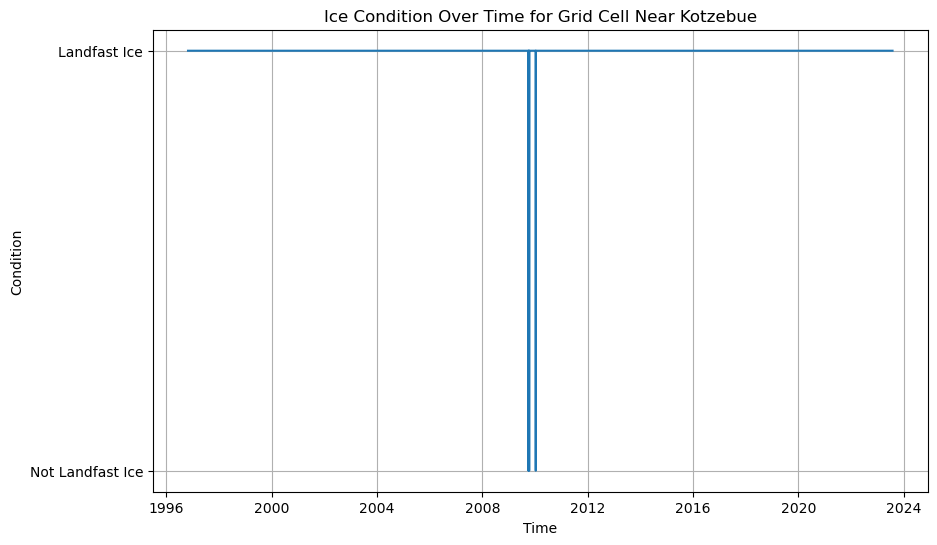

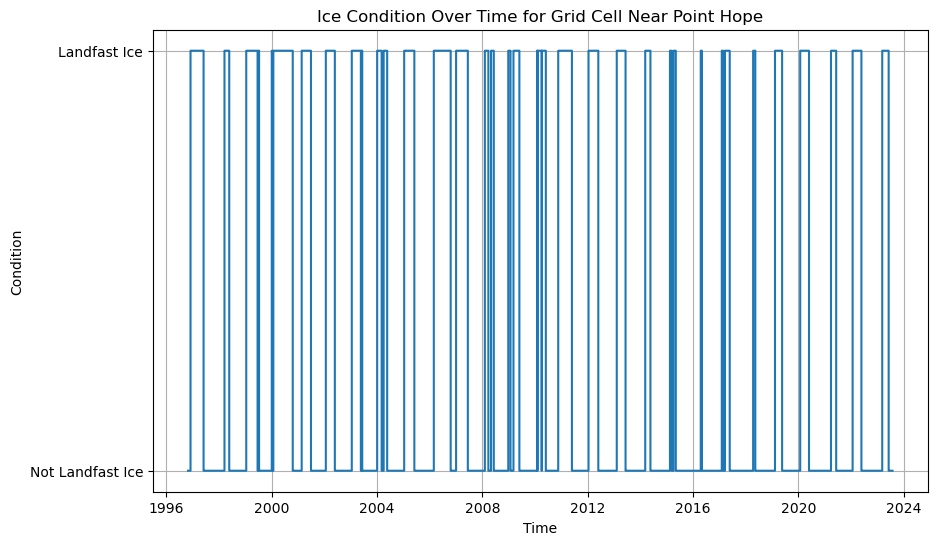

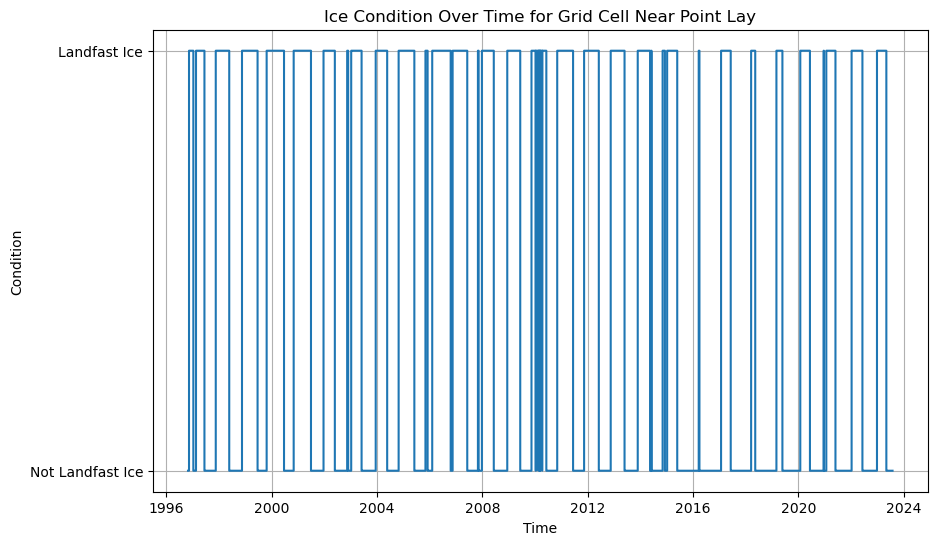

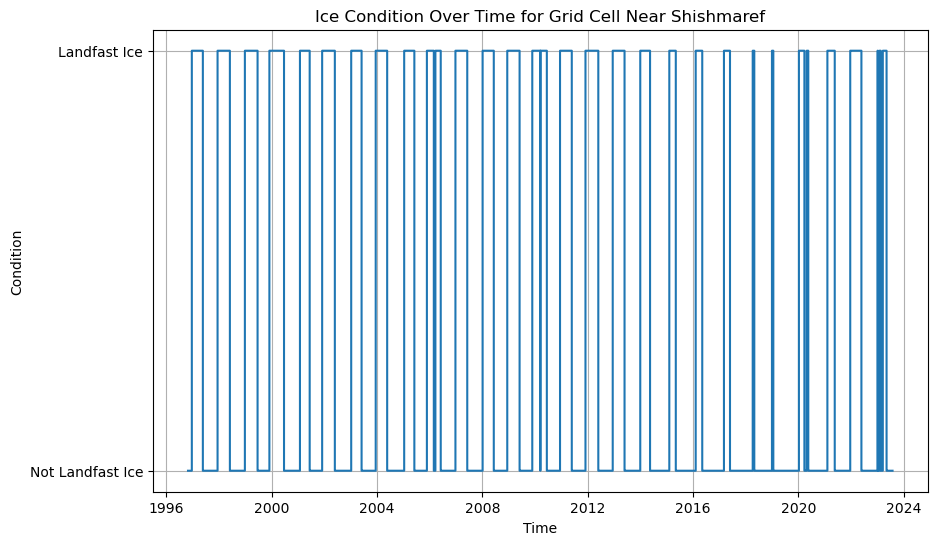

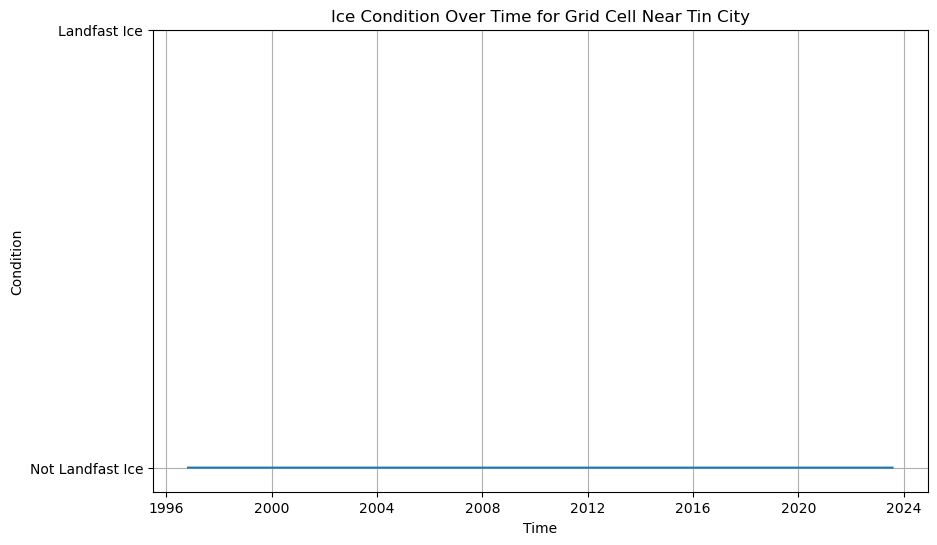

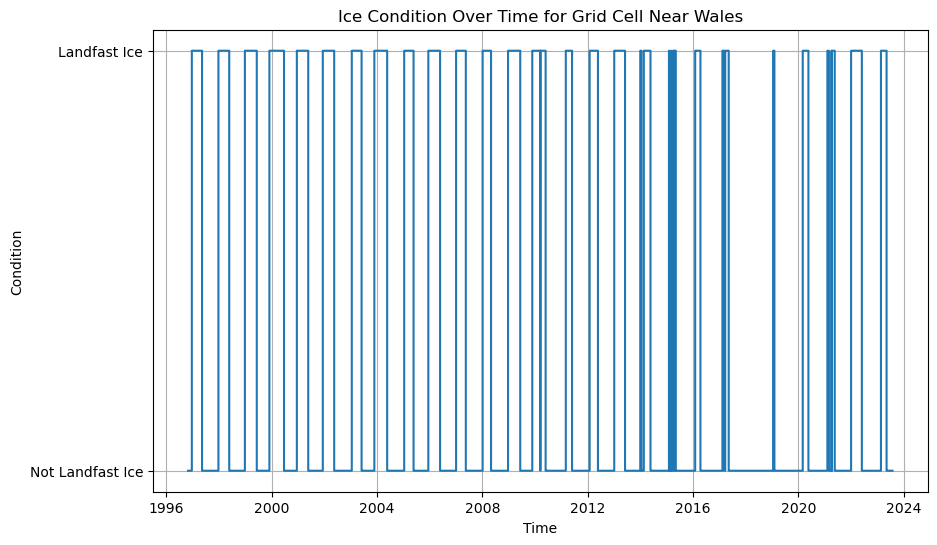

In [10]:
extract_and_plot_timeseries()

So, I'd interpret the above as follows: for this grid cell near Utqiaġvik, landfast ice was present for the majority of the 1996-97 ice season.

In [11]:



def extract_pixel_data(netcdf_files, x, y):
    """
    Extracts time series data for a given pixel (x, y) from a list of NetCDF files.

    Parameters:
        netcdf_files (list): A list of pathlib.Path objects pointing to NetCDF files.
        x (int): X-coordinate of the pixel.
        y (int): Y-coordinate of the pixel.

    Returns:
        dict: A dictionary where keys are the last 7 characters of each file name,
              and values are 1D NumPy arrays of time series data for the given pixel.
    """
    data_dict = {}
    
    for file in netcdf_files:
        # Open the NetCDF file using xarray
        dataset = xr.open_dataset(file)

        # Extract the time series for the given pixel
        pixel_data = dataset.sel(x=x, y=y, method="nearest")
        
        # Use the last 7 characters of the file name (excluding .nc) as the key
        key = file.stem[-7:]
        
        # Store the data in the dictionary
        data_dict[key] = pixel_data
    
    return data_dict

In [12]:
dd = extract_pixel_data(list_netcdf_files(BEAUFORT_NETCDF_DIR), x=-102597, y=2369251)

In [13]:
def prepare_heatmap_from_datasets(data_dict):
    """
    Converts a dictionary of xarray datasets into a DataFrame for a seaborn heatmap,
    reordered to start with October (month 10) and end with July (month 7).

    Parameters:
        data_dict (dict): A dictionary where keys are year ranges (e.g., '2012-13')
                          and values are xarray.Dataset objects.

    Returns:
        pd.DataFrame: A DataFrame where rows are days (1-31), columns are months (10-7),
                      and cells contain the average 'slie' value across all years.
    """
    heatmap_data = []

    for year_range, dataset in data_dict.items():
        # Extract the slie variable and time coordinates
        slie = dataset['slie'].values
        time = dataset['time'].values
        
        # Convert time to a DataFrame
        df = pd.DataFrame({
            'time': time,
            'slie': slie
        })
        df['month'] = pd.to_datetime(df['time']).dt.month
        df['day'] = pd.to_datetime(df['time']).dt.day
        
        # Append to the list
        heatmap_data.append(df)

    # Combine all years into a single DataFrame
    combined_df = pd.concat(heatmap_data)

    # Pivot to create a month-day structure
    heatmap_df = combined_df.pivot_table(
        index='day',       # Rows: Day of the month
        columns='month',   # Columns: Month
        values='slie',     # Values: Average 'slie'
        aggfunc='std'     # Handle duplicates by most frequent occurence
    )

    # Reorder the columns to match October-July order
    month_order = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7]
    heatmap_df = heatmap_df[[month for month in month_order if month in heatmap_df.columns]]

    return heatmap_df



def plot_seaborn_heatmap_with_custom_colors(heatmap_df):
    """
    Plots a seaborn heatmap with a custom colormap and labels for categorical data.

    Parameters:
        heatmap_df (pd.DataFrame): A DataFrame where rows are days, columns are months,
                                   and values correspond to categorical sea ice data.
    """
    # Define the value-label mapping
    value_label_map = {
        0: 'Not Landfast Ice',  # halfway between white and blue
        32: 'Coast Vector Shadow',  # black
        64: 'Out of Bounds',  # gray
        111: 'No Data',
        128: 'Land',
        255: 'Landfast Ice'
    }
    
    # Create a custom colormap
    colors = {
        0: '#a3c1e2',  # Halfway between white (#ffffff) and blue (#0000ff)
        32: '#000000',  # Black
        64: '#808080',  # Gray
        111: '#ff0000',  # Red for "No Data"
        128: '#00ff00',  # Green for "Land"
        255: '#0000ff'   # Blue for "Landfast Ice"
    }
    cmap = mcolors.ListedColormap([colors[key] for key in value_label_map.keys()])
    bounds = list(value_label_map.keys()) + [256]  # Add an upper bound for color mapping
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 9))
    sns.heatmap(
        heatmap_df,
        cmap=cmap,
        norm=norm,
        linewidths=0.5,  # Add gridlines with a width of 0.5
        cbar_kws={
            'ticks': list(value_label_map.keys()),
            'label': 'Landfast Sea Ice Conditions'
        }
    )
    
    # Add category labels to the color bar
    colorbar = plt.gca().collections[0].colorbar
    colorbar.set_ticklabels([value_label_map[key] for key in value_label_map.keys()])
    
    # Customize the plot
    plt.title("Heatmap of Median Daily Landfast Sea Ice Condition (October to July)")
    plt.xlabel("Month")
    plt.ylabel("Day of Month")
    plt.xticks(ticks=np.arange(len(heatmap_df.columns)) + 0.5, labels=heatmap_df.columns, rotation=45)
    plt.yticks(ticks=np.arange(len(heatmap_df.index)) + 0.5, labels=heatmap_df.index)
    plt.show()


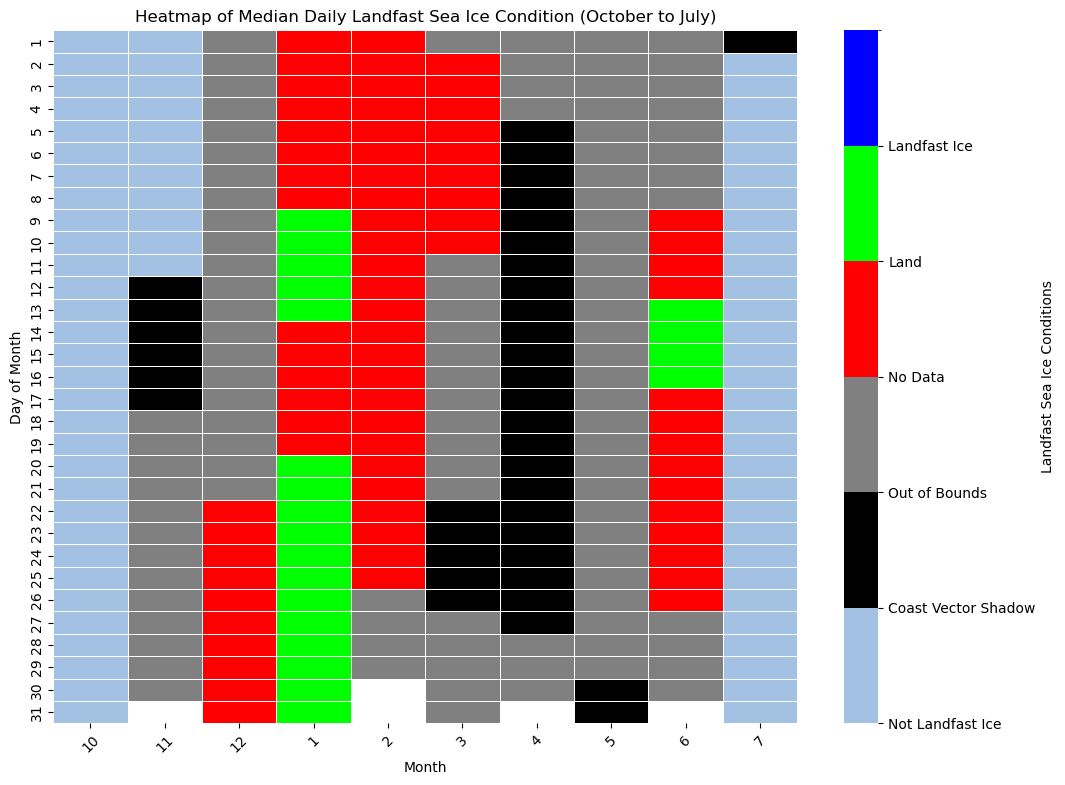

In [14]:
heatmap_df = prepare_heatmap_from_datasets(dd)
plot_seaborn_heatmap_with_custom_colors(heatmap_df)

In [15]:
def heatmap_variance(heatmap_df):
    """
    Plots a seaborn heatmap with a custom colormap and labels for categorical data.

    Parameters:
        heatmap_df (pd.DataFrame): A DataFrame where rows are days, columns are months,
                                   and values correspond to categorical sea ice data.
    """  
    # Plot the heatmap
    plt.figure(figsize=(12, 9))
    sns.heatmap(
        heatmap_df,
        cmap="magma",
        linewidths=0.5,  # Add gridlines with a width of 0.5
        cbar_kws={
            'label': 'Landfast Sea Ice Variance'
        }
    )
    
    # Add category labels to the color bar
    colorbar = plt.gca().collections[0].colorbar
    
    # Customize the plot
    plt.title("Heatmap of Daily Landfast Sea Ice Condition Variance (October to July)")
    plt.xlabel("Month")
    plt.ylabel("Day of Month")
    plt.xticks(ticks=np.arange(len(heatmap_df.columns)) + 0.5, labels=heatmap_df.columns, rotation=45)
    plt.yticks(ticks=np.arange(len(heatmap_df.index)) + 0.5, labels=heatmap_df.index)
    plt.show()


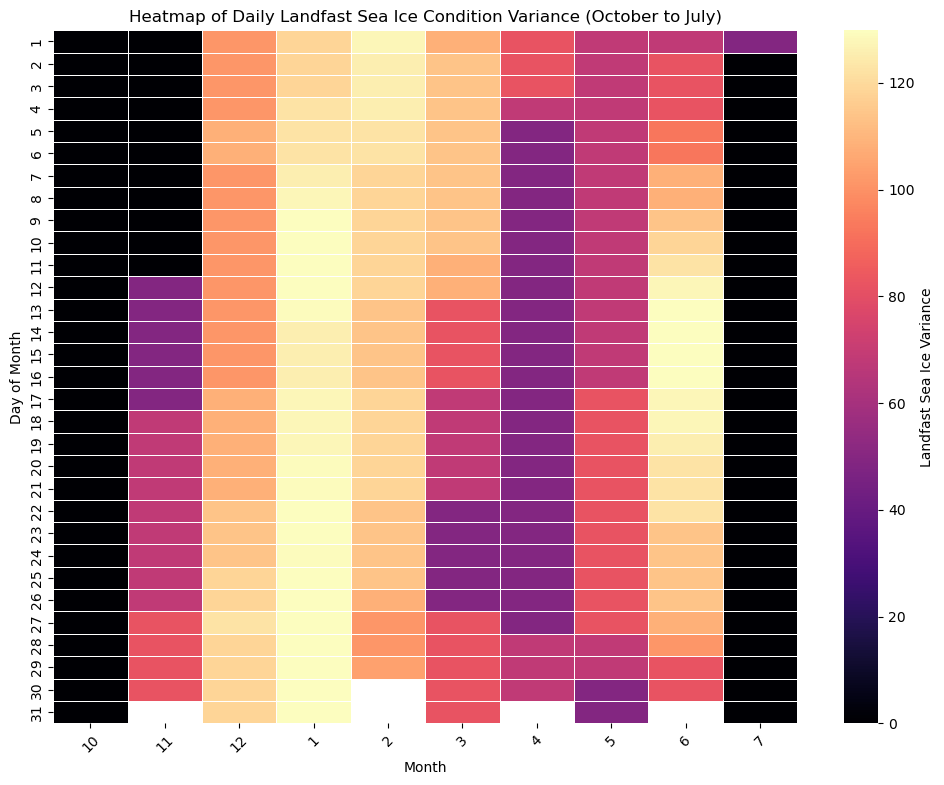

In [16]:
heatmap_variance(heatmap_df)

In [19]:
from pyproj import Transformer

# Initialize transformer from EPSG:3338 to EPSG:4326
transformer = Transformer.from_crs("EPSG:3338", "EPSG:4326", always_xy=True)

# Nearest neighbors in EPSG:3338
nearest_neighbors = {
    'Deadhorse': {'nearest_neighbor_x': 210868.41898, 'nearest_neighbor_y': 2266378.89492},
    'Kaktovik': {'nearest_neighbor_x': 397108.13843, 'nearest_neighbor_y': 2267302.40486},
    'Nuiqsut': {'nearest_neighbor_x': 107582.87949, 'nearest_neighbor_y': 2265757.97764},
    'Prudhoe Bay': {'nearest_neighbor_x': 215276.75919, 'nearest_neighbor_y': 2267138.77673},
    'Utqiaġvik': {'nearest_neighbor_x': -102597.06776, 'nearest_neighbor_y': 2368251.60593},
    'Wainwright': {'nearest_neighbor_x': -236276.26846, 'nearest_neighbor_y': 2304971.31783},
    'Candle': {'nearest_neighbor_x': -360055.77799, 'nearest_neighbor_y': 1804181.96468},
    'Cape Lisburne': {'nearest_neighbor_x': -494853.87917, 'nearest_neighbor_y': 2146066.03177},
    'Deering': {'nearest_neighbor_x': -394304.82266, 'nearest_neighbor_y': 1816799.19935},
    'Diomede': {'nearest_neighbor_x': -677501.22952, 'nearest_neighbor_y': 1833899.2719},
    'Elephant Point': {'nearest_neighbor_x': -329718.3704, 'nearest_neighbor_y': 1830434.80902},
    'Kivalina': {'nearest_neighbor_x': -446876.42931, 'nearest_neighbor_y': 2009841.09612},
    'Kiwalik': {'nearest_neighbor_x': -355159.97287, 'nearest_neighbor_y': 1807151.7589},
    'Kotzebue': {'nearest_neighbor_x': -377200.61298, 'nearest_neighbor_y': 1906880.17964},
    'Point Hope': {'nearest_neighbor_x': -526228.42456, 'nearest_neighbor_y': 2093141.82263},
    'Point Lay': {'nearest_neighbor_x': -354077.66064, 'nearest_neighbor_y': 2222399.58791},
    'Shishmaref': {'nearest_neighbor_x': -541106.53038, 'nearest_neighbor_y': 1860348.96552},
    'Tin City': {'nearest_neighbor_x': -644439.95796, 'nearest_neighbor_y': 1803067.85104},
    'Wales': {'nearest_neighbor_x': -645546.82339, 'nearest_neighbor_y': 1807631.0954}
}

# Transform coordinates to latitude/longitude
lat_lon_neighbors = {}
for location, coords in nearest_neighbors.items():
    x, y = coords['nearest_neighbor_x'], coords['nearest_neighbor_y']
    lon, lat = transformer.transform(x, y)
    lat_lon_neighbors[location] = {'latitude': round(lat, 4), 'longitude': round(lon, 4)}

# Print results
for location, coords in lat_lon_neighbors.items():
    print(f"{location}: {coords}")


Deadhorse: {'latitude': 70.2993, 'longitude': -148.4942}
Kaktovik: {'latitude': 70.1056, 'longitude': -143.6875}
Nuiqsut: {'latitude': 70.3527, 'longitude': -151.1869}
Prudhoe Bay: {'latitude': 70.3028, 'longitude': -148.3779}
Utqiaġvik: {'latitude': 71.2926, 'longitude': -156.7956}
Wainwright: {'latitude': 70.6301, 'longitude': -160.2603}
Candle: {'latitude': 66.0019, 'longitude': -161.933}
Cape Lisburne: {'latitude': 68.8687, 'longitude': -166.2243}
Deering: {'latitude': 66.0759, 'longitude': -162.7157}
Diomede: {'latitude': 65.7769, 'longitude': -168.8938}
Elephant Point: {'latitude': 66.2676, 'longitude': -161.3338}
Kivalina: {'latitude': 67.7282, 'longitude': -164.532}
Kiwalik: {'latitude': 66.0336, 'longitude': -161.8338}
Kotzebue: {'latitude': 66.8995, 'longitude': -162.5982}
Point Hope: {'latitude': 68.3447, 'longitude': -166.7331}
Point Lay: {'latitude': 69.7577, 'longitude': -163.052}
Shishmaref: {'latitude': 66.2569, 'longitude': -166.0729}
Tin City: {'latitude': 65.5707, 'l

In [20]:
-236200 <= -661250 <= 719400

False

In [21]:
2180000 <= 2424381 <= 2510000

True

In [22]:
-859500 <= -661250 <= -236000

True

In [23]:
1796000 <= 2424381 <= 2423200

False

In [24]:
def validate_latlon_in_bboxes(lat, lon, bboxes):
    """Validate if a lat and lon are within a list of bounding boxes.

    Args:
        lat (float): latitude
        lon (float): longitude
        bboxes (list): list of bounding boxes in the format [lon_min, lat_min, lon_max, lat_max]
    Returns:
        bool: True if the coordinates are within the bounding boxes, else 422
    """
    lat = float(lat)
    lon = float(lon)
    for bbox in bboxes:
        valid_lat = bbox[1] <= lat <= bbox[3]
        valid_lon = bbox[0] <= lon <= bbox[2]
        if valid_lat and valid_lon:
            return True
    return 422

bbox_test =  [[-159.9619, 69.4952, -133.8188, 71.603], [-172.4834, 65.0409, -160.5616, 71.7106]]
bbox_a = [[-159.9619, 69.4952, -133.8188, 71.603]]
bbox_b = [[-172.4834, 65.0409, -160.5616, 71.7106]]



In [30]:
validate_latlon_in_bboxes(71, -172, bbox_test)

True

In [31]:
validate_latlon_in_bboxes(71, -172, bbox_a)

422

In [32]:
validate_latlon_in_bboxes(71, -172, bbox_b)

True